In [1]:
:set -i./src
:load NotebookPrelude

The `NotebookPrelude` aimes to make it somewhat easy to:

- Define topologies, i.e. graphs with `BearerCharacteristic` edge weights.
- Compute statistics on those topologies, starting with `all_pairs_time_to_send`.
- Display the topologies via graphviz.
- Construct and display charts.

This notebook will show how to do these things, in no particular order.

To start, you can use `chart_numeric_xy` and a state-monad-lens style to set up charts.

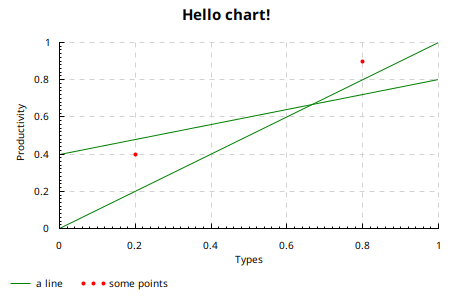

In [2]:
chart_numeric_xy $ do
  layout_title .= "Hello chart!"
  layout_x_axis . laxis_title .= "Types"
  layout_y_axis . laxis_title .= "Productivity"
  showPlot' $ do
    plot_lines_title .= "a line"
    plot_lines_style .= mk (line_color .= opaque green)
    plot_lines_values .= [[(0,0),(1,1)],[(0,0.4),(1,0.8)]]
  showPlot' $ do
    plot_points_title .= "some points"
    plot_points_style .= mk (do
      point_color .= opaque red
      point_radius .= 2.0)
    plot_points_values .= [(0.2,0.4), (0.8, 0.9)]

Topologies can be manually constructed using the `Algebra.Graph.Labelled.AdjacencyMap` module, along with `DeltaQ.Topography.edge :: e -> Last e` for edges (edge labels must be a `Semigroup`, in order to deal with multiple edges in an overlay).

Currently, there are some functions intended to help generate topologies in `DeltaQ.Examples.Gen`. There is also `DeltaQ.Examples.AWS` containing some graphs based on actual Amazon Web Services data.

In [3]:
-- A graph in which the edges are `SimpleGS`
let manual_graph = overlays
      [ 'A' -< edge (mkGS 0.05 1.0e-05) >- 'B'
      , 'B' -< edge (mkGS 0.05 1.0e-05) >- 'C'
      ]

-- manual_graph, but using a path generator.
-- The edge label generator is `pure (mkGS 0.05 1.0e-05)` in `Identity` but could instead randomly generate
-- weights, for instance.
let auto_graph = runIdentity (path (pure (mkGS 0.05 1.0e-05)) ('A' :| ['B', 'C']) (const pure))

-- For fun, we'll take the symmetric closure of this cycle, giving essentially an undirected graph.
let a_cycle = symmetricClosure (runIdentity (NotebookPrelude.cycle (pure (mkGS 0.05 1.0e-05)) ('A' :| ['B', 'C', 'D'])))

Showing graphs is straightforward but rather limited. We just use graphviz defaults. For big graphs, you'll probably find it to be useless.

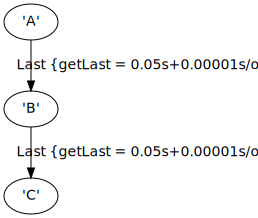

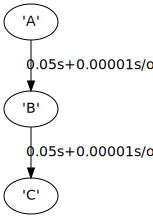

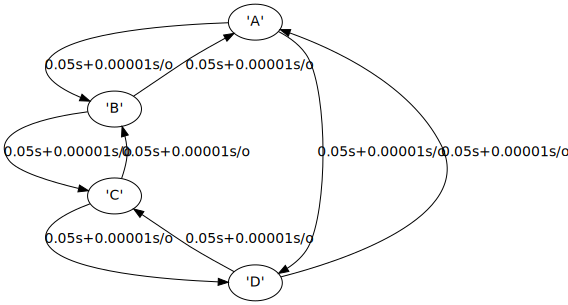

In [4]:
showTopology graphShowLabels manual_graph
showTopology graphShowLabels auto_graph
showTopology graphShowLabels a_cycle

Finally, you can bring it all together to chart stats about a topology.

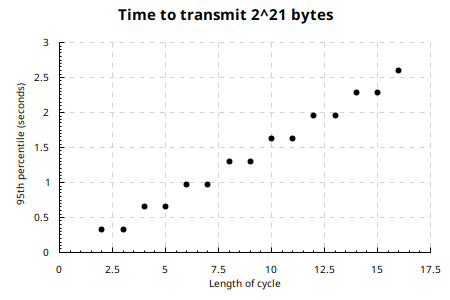

In [5]:
-- For cycles of length 2 to 16, how long until 95% of the pairs of peers would
-- transmit 2^21 bytes between them
let cycles_data :: [(Double, Double)]
    cycles_data = do
      n <- [2..16]
      let gr = symmetricClosure (cycle_of_length 0.006 3.27e-05 n)
          times = all_pairs_time_to_send (2 ^ 21) gr
      pure (fromIntegral n, percentile 95 (flatten_data times))
      
chart_numeric_xy $ do
  layout_title .= "Time to transmit 2^21 bytes"
  layout_x_axis . laxis_title .= "Length of cycle"
  layout_y_axis . laxis_title .= "95th percentile (seconds)"
  showPlot' $ do
    plot_points_style .= mk (point_radius .= 3.0)
    plot_points_values .= cycles_data